for each driver, generates the ideal standard route that the driver will have the least divergence.

**OUTPUT**

3. a file called perfectRoute.json that contains for each driver what would be the perfect ideal route. The
format of the file is as follows:

{driver:C, 

route:[

{from:‘Rome’, to:‘Milan’, merchandise: {milk:4, pens:4, butter:20}},

{from:‘Milan’, to:‘Bergamo’, merchandise: {milk:5, honey:19, butter:10, tomatoes:20}},

{from:‘Bergamo’, to:‘Venezia’, merchandise:{butter:47, pens:2, tomatoes:1}}

]

},

{driver:E,
 
route:[

{from:‘Bolzano’, to:‘Trento’, merchandise: {milk:2, pens:10, butter:22}},

{from:‘Trento’, to:‘Verona’, merchandise: {milk:15, tomatoes:4}},

{from:‘Verona’, to:‘Venezia’, merchandise:{butter:7, coca-cola:21, tomatoes:10}}

]

},

In [2]:
import os
HOME = os.getcwd()
print('HOME: ',HOME)

import json
import random
import pandas as pd
import sys
import lxml
import sklearn as sk
import numpy as np
import umap

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

HOME:  c:\Users\User\Desktop\VSCodeProjects\DataMining\DataMiningProject23-24


In [3]:
STANDARD_FILE = 'standard.json'
ACTUAL_FILE = 'actual.json'

OUTPUT_FILE = 'perfectRoute.json'
DATA_DIR = os.path.join(HOME,'data')

In [4]:
# load standard and actual data
with open(os.path.join('data',STANDARD_FILE)) as f:
    standard = json.load(f)

with open(os.path.join('data', ACTUAL_FILE)) as f:
    actual = json.load(f)

# load the data into a dataframe
dfStandard = pd.DataFrame(standard)
dfActual = pd.DataFrame(actual)

# print head of the dataframes
print(dfStandard.head())
print(dfActual.head())

# get the unique cities, items and drivers of the standard data
cities = []
items = []
drivers = []
longestRoute = 0
shortestRoute = np.inf
for index, s in dfStandard.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    for trip in route:
        cities.append(trip['from']) 
        items.extend(trip['merchandise'].keys())
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
        
    if len(route) < shortestRoute:
        shortestRoute = len(route)

for index, s in dfActual.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    drivers.append(s['driver'])
    for trip in route:
        cities.append(trip['from'])
        items.extend(trip['merchandise'].keys())
        
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
    
    if len(route) < shortestRoute:
        shortestRoute = len(route)

# find the unique cities and items
uniqueCities = sorted(list(set(cities)))
uniqueItems = sorted(list(set(items)))
uniqueDrivers = sorted(list(set(drivers)))

print("Unique cities: ", uniqueCities)
print("Unique items: ", uniqueItems)
print("Unique drivers: ", uniqueDrivers)

print("Number of cities: ", len(uniqueCities))
print("Number of items: ", len(uniqueItems))
print("Number of drivers: ", len(uniqueDrivers))

print("Longest route: ", longestRoute)
print("Shortest route: ", shortestRoute)

   id                                              route
0  s0  [{'from': 'Grosseto', 'to': 'Sanremo', 'mercha...
1  s1  [{'from': 'Turin', 'to': 'Pozzuoli', 'merchand...
2  s2  [{'from': 'Grosseto', 'to': 'Anzio', 'merchand...
3  s3  [{'from': 'Lecce', 'to': 'Genoa', 'merchandise...
4  s4  [{'from': 'Ercolano', 'to': 'Novara', 'merchan...
   id driver sroute                                              route
0  a0      B     s0  [{'from': 'Grosseto', 'to': 'Sanremo', 'mercha...
1  a1      C     s0  [{'from': 'Sanremo', 'to': 'Verona', 'merchand...
2  a2      O     s0  [{'from': 'Grosseto', 'to': 'Sanremo', 'mercha...
3  a3      H     s0  [{'from': 'Grosseto', 'to': 'Sanremo', 'mercha...
4  a4      D     s0  [{'from': 'Grosseto', 'to': 'Sanremo', 'mercha...
Unique cities:  ['Acireale', 'Afragola', 'Agrigento', 'Alessandria', 'Altamura', 'Anzio', 'Arezzo', 'Aversa', 'Barletta', 'Benevento', 'Bergamo', 'Bisceglie', 'Bitonto', 'Bolzano-Bozen', 'Brindisi', 'Busto Arsizio', 'Cagliari', 'Car

# Vectorizing the Routes 

Using one-hot encoding of the all possible tuple of two cities (from-to) and the summed merchandise along a route weighted by the total number of merch

In [5]:
def create_couples(items):
    results = []

    for i in items:
        for j in items:
            if i==j:
                continue
            results.append((i,j))

    return results

In [6]:
def create_feature_vector(data, list_of_cities, list_of_items, use_SVD=True):
    # create a feature vector for each row
    featureVector = []
    for index, row in data.iterrows():
        cityVector = np.zeros(len(list_of_cities), dtype=float)
        itemsVector = np.zeros(len(list_of_items), dtype=float)
        #idS = row['id']
        route = row['route']
        for trip in route:
            cityVector[list_of_cities.index((trip['from'], trip['to']))] = 1

            for item, n in trip["merchandise"].items():
                itemsVector[list_of_items.index(item)] += n

        itemsVector = itemsVector / np.sum(itemsVector)
        featureVector.append(np.concatenate((cityVector, itemsVector), axis=0))

    featureVector = np.array(featureVector).astype(float)
    if use_SVD:
        n_comp = len(dfStandard)
        X = csr_matrix(featureVector)
        svd = TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42)
        featureVector = svd.fit_transform(X)
    return featureVector

In [7]:
shingles = create_couples(uniqueCities) 

standard_vector = create_feature_vector(dfStandard, shingles, uniqueItems, use_SVD=False)
actual_vector = create_feature_vector(dfActual, shingles, uniqueItems, use_SVD=False)
standardIds = dfStandard['id'].tolist()
actualIds = dfActual['sroute'].tolist()

print('Standard vector shape: ', standard_vector.shape)
print('Standard labels: ', len(standardIds))
print('Actual vector shape: ', actual_vector.shape)
print('actual labels: ',len(actualIds))

Standard vector shape:  (100, 10050)
Standard labels:  100
Actual vector shape:  (1500, 10050)
actual labels:  1500


In [8]:
## Get the drivers
actual_drivers = dfActual['driver'].tolist()
print(len(actual_drivers))

1500


In [9]:
def assign_numbers(lst):
    element_to_number = {}
    result = []

    for element in lst:
        if element not in element_to_number:
            element_to_number[element] = len(element_to_number)

        result.append(element_to_number[element])

    return np.array(result, dtype=int)

## Visualize data using UMAP

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import umap
%matplotlib inline

In [11]:
from matplotlib.colors import Normalize

def normalize_array(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

def draw_umap(data, target, classnames, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title='', add_color_bar=False):
    fit = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
    u = fit.fit_transform(data)

    fig = plt.figure(figsize=(8,8))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=target, cmap='Spectral')
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=target, cmap='Spectral')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=target, cmap='Spectral', s=20)

    # Create a ScalarMappable object to associate with the colorbar
    norm = Normalize(vmin=target.min(), vmax=target.max())
    sm = plt.cm.ScalarMappable(cmap='Spectral',norm=norm)
    sm.set_array([])

    # Add colorbar
    if add_color_bar:
        cbar = plt.colorbar(sm, boundaries=np.arange(len(classnames)+1)-0.5, label='Class Labels', ax=ax)
        cbar.set_ticks(np.arange(len(classnames)))
        cbar.set_ticklabels(classnames)
    plt.title(title, fontsize=18)

    # Show the plot
    plt.show()

In [12]:
stackedVectors = np.vstack((standard_vector, actual_vector))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(standard_vector.shape[0]), np.ones(actual_vector.shape[0])))

stackedVectors shape (1600, 10050)


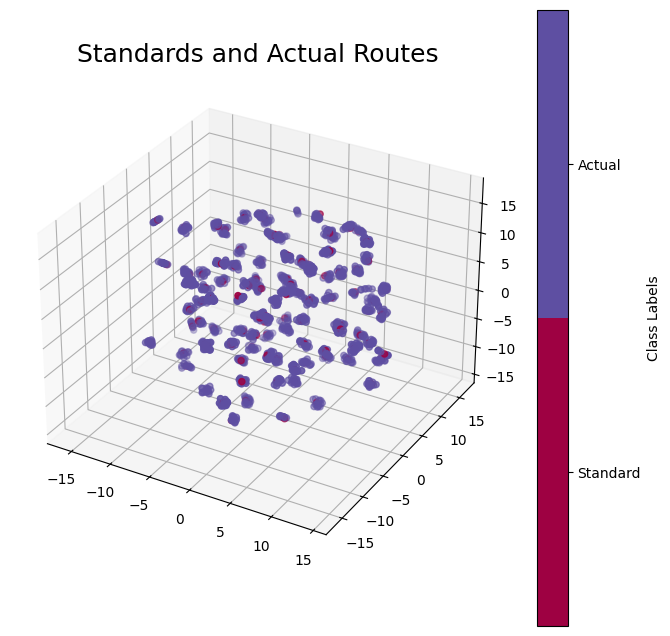

In [13]:
draw_umap(stackedVectors, types, ['Standard', 'Actual'], min_dist=0.9, n_neighbors=3, n_components=3, metric='cosine', title='Standards and Actual Routes', add_color_bar=True)

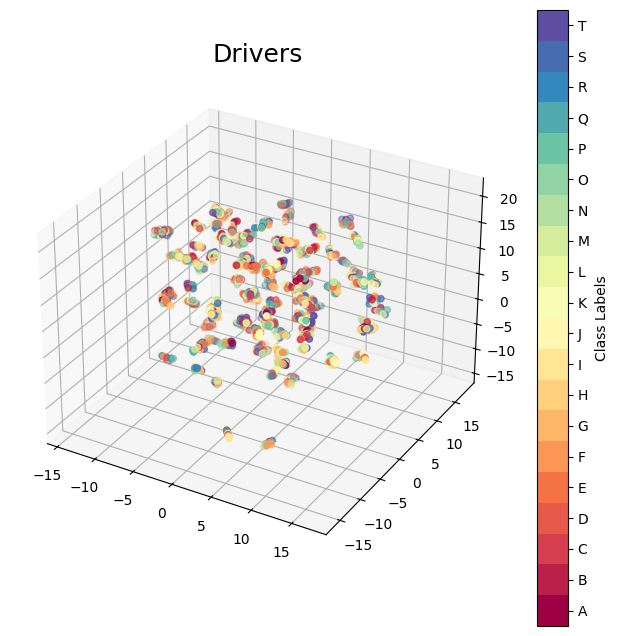

In [14]:
draw_umap(actual_vector, assign_numbers(actual_drivers), np.unique(actual_drivers), min_dist=0.9, n_neighbors=3, n_components=3, metric='cosine', title='Drivers', add_color_bar=True)

## Visualize data using TSNE

In [15]:
# visualize the data in a 3D plot using TSNE, in red the standard data and in blue the actual data
tsne = TSNE(n_components=3, random_state=0, perplexity=40)

# stack the vectors and create a vector of types (0 for standard, 1 for actual)
stackedVectors = np.vstack((standard_vector, actual_vector))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(standard_vector.shape[0]), np.ones(actual_vector.shape[0])))

# Fix the IndexError by using the stackedVectors instead of actualVectors for tsne.fit_transform()
vectorsTSNE = tsne.fit_transform(stackedVectors, types)

stackedVectors shape (1600, 10050)


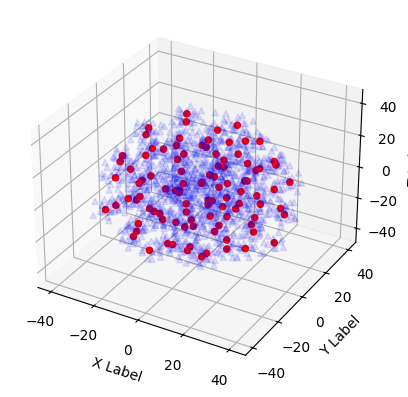

In [16]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectorsTSNE[types==0,0], vectorsTSNE[types==0,1], vectorsTSNE[types==0,2], c='r', marker='o', alpha=1)
ax.scatter(vectorsTSNE[types==1,0], vectorsTSNE[types==1,1], vectorsTSNE[types==1,2], c='b', marker='^', alpha=0.1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [17]:
unique_labels = np.unique(standardIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in standardIds]

# Create a trace for each type
trace0 = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)


# Create a color map that maps each unique label to a color
unique_labels = np.unique(actualIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in actualIds]

trace1 = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=5,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.3,
        symbol='circle'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

## Best route for each driver

In [18]:
pd.Series(actual_drivers).value_counts()

K    91
R    86
N    84
G    83
D    81
A    81
P    81
F    80
S    75
H    75
C    75
O    74
M    72
I    71
E    70
L    69
Q    67
B    65
T    63
J    57
Name: count, dtype: int64

In [19]:
drivers, sroutes = [], []
for index, row in dfActual.iterrows():
    drivers.append(row['driver'])
    sroutes.append(row['sroute'])

results = pd.DataFrame((drivers, sroutes))
results = results.T
results.columns = ['Driver', 'Sroute']
results

,Driver,Sroute
0,B,s0
1,C,s0
2,O,s0
3,H,s0
4,D,s0
...,...,...
1495,M,s99
1496,E,s99
1497,L,s99
1498,P,s99


In [20]:
driver_a = actual_vector[results[results['Driver'] == 'A'].index]

In [21]:
# visualize the data in a 3D plot using TSNE, in red the standard data and in blue the actual data
tsne = TSNE(n_components=3, random_state=0, perplexity=5)

# stack the vectors and create a vector of types (0 for standard, 1 for actual)
stackedVectors = np.vstack((standard_vector, driver_a))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(standard_vector.shape[0]), np.ones(driver_a.shape[0])))

# Fix the IndexError by using the stackedVectors instead of actualVectors for tsne.fit_transform()
vectorsTSNE = tsne.fit_transform(stackedVectors, types)

stackedVectors shape (181, 10050)


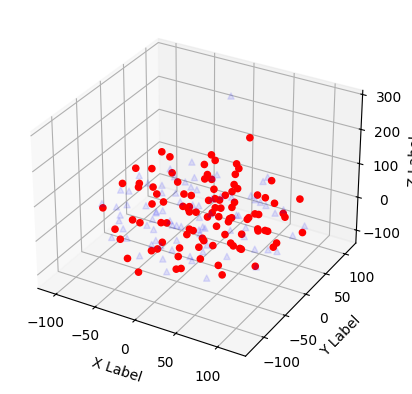

In [22]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectorsTSNE[types==0,0], vectorsTSNE[types==0,1], vectorsTSNE[types==0,2], c='r', marker='o', alpha=1)
ax.scatter(vectorsTSNE[types==1,0], vectorsTSNE[types==1,1], vectorsTSNE[types==1,2], c='b', marker='^', alpha=0.1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [23]:
## looping through the clusters (standard routes) and counting the number of actual belonging to each cluster and the inter-cluster confidence,
## then picking the most voted one (number of sample * confidence)
## and assign as perfect route the actual route that minimize the intra-cluster cosine distance
from sklearn.metrics.pairwise import cosine_similarity  

best_driver_routes = {}
for driver in uniqueDrivers:
    #single_driver = actual_vector[results[results['Driver'] == driver].index]
    single_driver = results[results['Driver'] == driver]
    best_similarity = 0.0
    for route in np.unique(single_driver.Sroute):
        n = len(single_driver[single_driver['Sroute'] == route])
        if n==1:
            avg_similarity = 0.0
        else:
            vector = actual_vector[single_driver[single_driver['Sroute'] == route].index]
            similarity = cosine_similarity(vector)
            avg_similarity = (np.sum(similarity) - n) / 2

        if avg_similarity > best_similarity:
            best_route = route
            best_similarity = avg_similarity
    best_driver_routes[driver] = best_route

best_driver_routes

{'A': 's71',
 'B': 's14',
 'C': 's67',
 'D': 's69',
 'E': 's44',
 'F': 's65',
 'G': 's63',
 'H': 's61',
 'I': 's73',
 'J': 's21',
 'K': 's62',
 'L': 's38',
 'M': 's0',
 'N': 's76',
 'O': 's70',
 'P': 's60',
 'Q': 's72',
 'R': 's16',
 'S': 's83',
 'T': 's19'}

## Create the perfect routes

In [24]:
from sklearn.metrics.pairwise import cosine_distances

data = []
for key, value in best_driver_routes.items():

    single_driver = results[results['Driver'] == key]
    vectors = actual_vector[single_driver[single_driver['Sroute'] == value].index]
    distances = cosine_distances(vectors)
    distances = [np.sum(v) for v in distances]
    best_idx = [i for i in range(len(distances)) if distances[i] == max(distances)].pop()


    actual_idx = results[results['Driver'] == key]
    actual_idx = actual_idx[actual_idx['Sroute'] == value].index.tolist()
    actual_idx = actual_idx[best_idx]
    data.append({'driver':key, 'route':dfActual.loc[actual_idx].route})

# Write the data to the JSON file
file_path = os.path.join(DATA_DIR, OUTPUT_FILE) #"standard.json"
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=2)

## Plot the perfect routes for each driver

In [27]:
with open(os.path.join('data',OUTPUT_FILE)) as f:
    perfect = json.load(f)

dfPerfect = pd.DataFrame(perfect)

perfect_vector = create_feature_vector(dfPerfect[dfPerfect['driver'] == 'A'], create_couples(uniqueCities), uniqueItems, use_SVD=False)
#perfectIds = dfPerfect['driver'].tolist()

In [28]:
driver_a = actual_vector[results[results['Driver'] == 'A'].index]

# visualize the data in a 3D plot using TSNE, in red the standard data and in blue the actual data
tsne = TSNE(n_components=3, random_state=0, perplexity=5)

# stack the vectors and create a vector of types (0 for standard, 1 for actual)
stackedVectors = np.vstack((perfect_vector, driver_a))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(perfect_vector.shape[0]), np.ones(driver_a.shape[0])))

# Fix the IndexError by using the stackedVectors instead of actualVectors for tsne.fit_transform()
vectorsTSNE = tsne.fit_transform(stackedVectors, types)

stackedVectors shape (82, 10050)


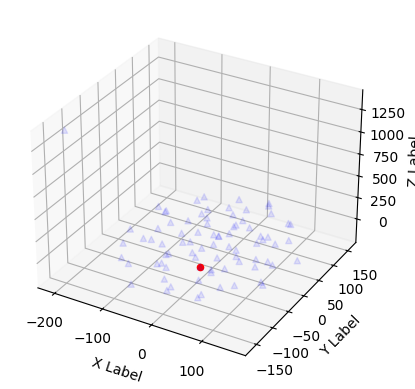

In [29]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectorsTSNE[types==0,0], vectorsTSNE[types==0,1], vectorsTSNE[types==0,2], c='r', marker='o', alpha=1)
ax.scatter(vectorsTSNE[types==1,0], vectorsTSNE[types==1,1], vectorsTSNE[types==1,2], c='b', marker='^', alpha=0.1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()